/**********************************************************************************
 * Copyright (c) 2023 Process Systems Engineering (AVT.SVT), RWTH Aachen University
 *
 * This program and the accompanying materials are made available under the
 * terms of the Eclipse Public License 2.0 which is available at
 * http://www.eclipse.org/legal/epl-2.0.
 *
 * SPDX-License-Identifier: EPL-2.0
 *
 * The source code can be found here:
 * https://github.com/iAMB-RWTH-Aachen/Ustilago_maydis-GEM/tree/master/data/AcetateCofeed
 
 **********************************************************************************/




Date: 04.02.2023 <br/>
File name: Growth rate over glucose and acetate flux.ipynb <br/>
Description: This script provides the FBA computations of the growth rate for different combinations of acetate and glucose uptake (cf. Figure 1c in the original manuscript).
The COBRApy package (https://doi.org/10.1186/1752-0509-7-74  ) is used to together with the solver Gurobi 9.5.2 to solve the 
linear programming problems. <br/>
@authors: Manuel Boßmann, Anita Ziegler, Ulf Liebal, Alexander Mitsos



In [1]:
from os.path import join


# loading cobrapy, a library dedicated to the analysis of genome scale metabolic models
from cobra.io import read_sbml_model


# loading matplotlib, a library for visualization
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'


# loading colormap for matplotlib
from cmcrameri import cm

In [2]:
#load iUma22v1.1.xml model
#https://github.com/iAMB-RWTH-Aachen/Ustilago_maydis-GEM
ModelFile = join('..', '..','model','iUma22v1.1.xml')
model=read_sbml_model(ModelFile)

In [3]:
#Glucose uptake flux experimentally determined in mmol/g_dw/h, see Fig. 1b/c
list_glc_uptake = [0.47888322,0.884593131,0.035850649,0.883037206,0.696779908,0.295534291,0.991161185,0.233589979,0.926129362]

In [4]:
#Glucose uptake flux experimentally determined in mmol/g_dw/h, see Fig. 1b/c
list_ace_uptake = [0.71415659,0.393209836,0.846109669,0.122975256,0.23858602,0.211394584,0.069933364,0.126648204,0.164639249]

In [5]:
list_growth_rate = []
list_glc_flux = []
list_ace_flux = []

In [6]:
#Simulate biomass growth with different acetate and glucose fluxes
model.objective = "BIOMASS_REACTION"

for x in range(0,len(list_glc_uptake)):

    #set feed via medium
    medium = model.medium
    medium['EX_glc__D_e']=list_glc_uptake[x]
    medium['EX_ac_e']=list_ace_uptake[x]
    model.medium = medium

    #The next step computes the outputs of the optimization problem
    solution = model.optimize()
    #For some uptake flux inputs the optimization problem is not solvable. This behavior is expected.
    #The unsolvability is e.g. due to a negative growth rate, which is not allowed.
    #The infeasible results are omitted.
    if solution.status != "infeasible":
        list_growth_rate.append(round(model.reactions.BIOMASS_REACTION.flux,5))
        list_glc_flux.append(round(-model.reactions.EX_glc__D_e.flux,5))
        list_ace_flux.append(round(-model.reactions.EX_ac_e.flux,5))
    else:
        pass

c:\Users\Manuel\AppData\Local\Programs\Python\Python310\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


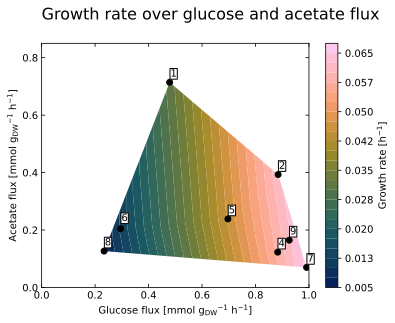

In [7]:
#creating the graph
cmap = cm.batlow

fig, ax =plt.subplots(figsize = (6,4.5))
ax.set_xlim([0, 1])
ax.set_ylim([0, 0.85])
ax.set_title("Growth rate over glucose and acetate flux\n", loc = "left", fontsize = 16)
ax.set_xlabel("Glucose flux [mmol g$_{\mathrm{DW}}$$^{-1}$ h$^{-1}$]")
ax.set_ylabel("Acetate flux [mmol g$_{\mathrm{DW}}$$^{-1}$ h$^{-1}$]")
ax.tick_params(direction = "in", top = True, right = True)
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8])

plot_growth_rate = ax.tricontourf(list_glc_flux, list_ace_flux, list_growth_rate, cmap = cmap, levels = 24)

ax.scatter(list_glc_flux, list_ace_flux, c= "black")

for i in range(len(list_glc_uptake)):
    ax.annotate(str(i+1), (list_glc_uptake[i]+0.003, list_ace_uptake[i]+0.02), bbox=dict(facecolor='white', edgecolor='black', pad=0.5))

colorbar = plt.colorbar(plot_growth_rate, cmap = cmap, format = "%.3f")
colorbar.ax.set_ylabel('Growth rate [h$^{-1}$]', fontsize = 10)

plt.show()